**Task**

On the dataset [bottle.csv](https://www.kaggle.com/datasets/sohier/calcofi?select=bottle.csv), train polynomial regression with a fixed polynomial degree of 4, but with added L2 regularization. For the lambda parameter, try values from the set {0, 0.001, 0.01, 0.1, 1, 10, 100}. It is okay to start from a complete copy of the previous file. Running the program should create two graphs similar to those in the previous part of the problem: a graph of all data with 7 regression curves (for different lambda values) and a graph showing the dependency of the final cost function on the entire dataset on the lambda parameter. What can we observe now? Discuss in the comment below the code.

**The goal is to predict water temperature based on salinity information about the dataset is here.**

X - salinity column Y - water temperature column

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Data preprocessing
file_path = 'bottle.csv'
data = pd.read_csv(file_path, usecols=['Salnty', 'T_degC'])

data = data.dropna()                                # clean null values
data = data.reset_index(drop=True)
data_700 = data.iloc[:700]                          # first 700 rows

data_700 = data_700.sample(frac=1).reset_index(drop=True)  # shuffle

# Normalization
for column in data_700.columns:
    data_700[column] = (data_700[column] - np.mean(data_700[column])) / np.std(data_700[column])

num_rows, num_columns = data_700.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)
print(data_700.head(n=5), '\n')

X = data_700['Salnty'].astype('float32')
Y = data_700['T_degC'].astype('float32')

Number of rows: 700
Number of columns: 2
     T_degC    Salnty
0 -1.033423  0.740058
1 -0.214245  0.482839
2  0.108857 -0.162099
3  0.399322 -0.633036
4  0.712633 -0.373926 



Epoch: 5/10| Avg loss: 0.14769
Epoch: 10/10| Avg loss: 0.12345
Gotov za lambda 0
Epoch: 5/10| Avg loss: 0.14789
Epoch: 10/10| Avg loss: 0.12376
Gotov za lambda 0.001
Epoch: 5/10| Avg loss: 0.14964
Epoch: 10/10| Avg loss: 0.12655
Gotov za lambda 0.01
Epoch: 5/10| Avg loss: 0.16621
Epoch: 10/10| Avg loss: 0.15125
Gotov za lambda 0.1
Epoch: 5/10| Avg loss: 0.27341
Epoch: 10/10| Avg loss: 0.27317
Gotov za lambda 1
Epoch: 5/10| Avg loss: 0.59400
Epoch: 10/10| Avg loss: 0.59401
Gotov za lambda 10
Epoch: 5/10| Avg loss: 0.91923
Epoch: 10/10| Avg loss: 0.91923
Gotov za lambda 100


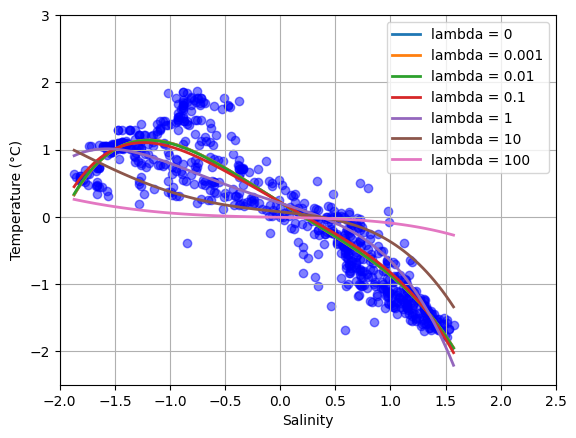

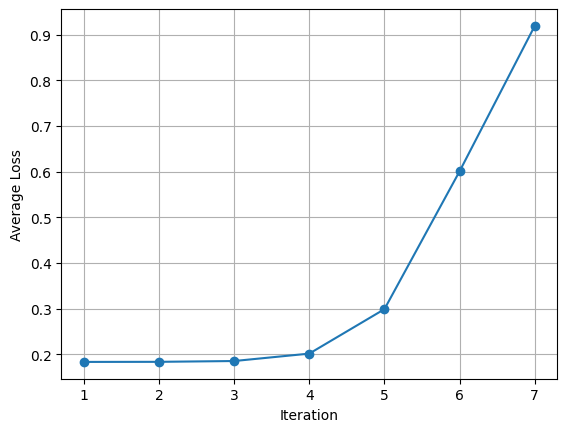

In [3]:
# X matrix
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)

# Predicition
def pred(x, w, b):
    w_col = tf.reshape(w, (nb_features, 1))
    hyp = tf.add(tf.matmul(x, w_col), b)
    return hyp

# Loss function
def loss(x, y, w, b, lmbd, reg = 'l2'):
    prediction = pred(x, w, b)
    y_col = tf.reshape(y, (-1, 1))
    mse = tf.reduce_mean(tf.square(prediction - y_col))

    if reg == 'l2':                                     # L2 regularization                         
        l2_reg = lmbd * tf.reduce_mean(tf.square(w))
        loss = tf.add(mse, l2_reg)
    else:
        loss = mse
    return loss

# Gradient calculation
def calc_grad(x, y, w, b, lmbd):
    with tf.GradientTape() as tape:
        loss_val = loss(x, y, w, b, lmbd)               # loss_val = scalar tensor

    w_grad, b_grad = tape.gradient(loss_val, [w, b])
    return w_grad, b_grad, loss_val

# Training step
def train_step(x, y, w, b, adam, lmbd):
    w_grad, b_grad, loss = calc_grad(x, y, w, b, lmbd)

    adam.apply_gradients(zip([w_grad, b_grad], [w, b]))

    return loss

nb_features = 4                                         # polynom degree = 4
lambdas = [0, 0.001, 0.01, 0.1, 1, 10, 100]

learning_rate = 0.001
nb_epochs = 10

# Plots
plt_rcurve, ax_rcurve = plt.subplots()
plt_loss, ax_loss = plt.subplots()

# Store losses for every epoch
losses = [[] for _ in range(len(lambdas))]

for i in range(len(lambdas)):
    lmbd = lambdas[i]

    adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feature_matrix = create_feature_matrix(X, nb_features)

    # Model parameters
    w = tf.Variable(tf.zeros(nb_features))
    b = tf.Variable(0.0)

    # Training loop
    for epoch in range(nb_epochs):

        # Stochastic Gradient Descent
        epoch_loss = 0
        nb_samples = X.shape[0]
        for sample in range(nb_samples):
            x = feature_matrix[sample].reshape((1, nb_features))
            y = Y[sample]

            curr_loss = train_step(x, y, w, b, adam, lmbd = lmbd)
            epoch_loss += curr_loss

        epoch_loss /= nb_samples
        losses[i].append(epoch_loss)
        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{nb_epochs}| Avg loss: {epoch_loss:.5f}')

    # Print message when training is done for the current polynomial degree
    print(f'Over for lambda {lmbd}')

    # Generate predictions using the trained model
    x_values = np.linspace(min(X), max(X), 100).reshape(-1, 1)
    feature_matrix = create_feature_matrix(x_values, nb_features)
    y_values = np.dot(feature_matrix, w.numpy()) + b.numpy()

    # Plot the regression curve
    ax_rcurve.plot(x_values, y_values, label=f'lambda = {lmbd}', linewidth=2)

# Regression curve plot - add points
ax_rcurve.scatter(X, Y, c='blue', alpha=0.5)
ax_rcurve.set_xlabel('Salinity')
ax_rcurve.set_ylabel('Temperature (°C)')
ax_rcurve.set_xlim([-2, 2.5])
ax_rcurve.set_ylim([-2.5, 3])
ax_rcurve.grid(True)
ax_rcurve.legend()
plt_rcurve.show()

# Loss plot
average_losses = [sum(loss) / len(loss) if loss else 0 for loss in losses]

# Plot
plt.plot(range(1, len(average_losses) + 1), average_losses, linestyle='-', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

**Conclusion**

The graph illustrates that a linear regression model using a fourth-degree polynomial achieves the lowest loss at low values of the lambda parameter for L2 regularization. As lambda increases, especially when the value exceeds 0.1, there is a significant increase in loss, indicating excessive regularization and a loss of flexibility in the model. The optimal value of lambda for this model is somewhere between 0 and 0.1, allowing the model to achieve optimal performance.

Regularization helps prevent the model from overfitting by penalizing large parameter values, thus encouraging all parameters to stay around zero or smaller values. As lambda increases, the regularization effect becomes stronger, leading to parameter values being pushed closer to zero, which can eventually result in a more simplified, less flexible model. When lambda becomes very large, the regularization effect dominates, causing all parameters to approach zero, resulting in a flatter, less flexible model, as illustrated in the graph for lambda = 100.